# Import Libraries

In [1]:
#Load the required libraries

import pandas as pd
import numpy as np

from datetime import datetime

import matplotlib.pyplot as plt
plt.style.use('seaborn-v0_8-darkgrid')


import prophet
from prophet import Prophet
from prophet.plot import plot_plotly, plot_components_plotly, add_changepoints_to_plot

from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, mean_squared_error,r2_score


import xgboost as xgb
from xgboost import plot_importance, plot_tree

import warnings
warnings.filterwarnings("ignore")

# Import Data

In [2]:
bitcoin_df = pd.read_csv("../data/BTCUSDT_final_clean.csv")

In [3]:
bitcoin_df.head()

,date,open,high,low,close,volume,quote_volume,count,taker_buy_volume,taker_buy_quote_volume
0,2020-01-01 00:00:00,7195.24,7196.25,7175.46,7177.02,511.814901,3.675857e+06,7640.0,226.153126,1.624289e+06
1,2020-01-01 01:00:00,7176.47,7230.00,7175.71,7216.27,883.052603,6.365953e+06,9033.0,570.721419,4.114804e+06
2,2020-01-01 02:00:00,7215.52,7244.87,7211.41,7242.85,655.156809,4.736719e+06,7466.0,357.180263,2.582514e+06
3,2020-01-01 03:00:00,7242.66,7245.00,7220.00,7225.01,783.724867,5.667367e+06,8337.0,394.810811,2.854987e+06
4,2020-01-01 04:00:00,7225.00,7230.00,7215.03,7217.27,467.812578,3.379094e+06,5896.0,243.514706,1.759053e+06


Here's a breakdown of each feature:

- **date**: This represents the opening time 
- **open**: This refers to the opening price of the trading instrument at the given period.

- **high**: This represents the highest price reached by the trading instrument during the specified period.

- **low**: This denotes the lowest price reached by the trading instrument during the specified period.

- **close**: This indicates the closing price of the trading instrument at the given period.

- **volume**: This refers to the total volume, typically the quantity of the trading instrument, traded during the specified period.


- **quote_volume**: This refers to the total volume in terms of the quote asset. The quote asset is the asset used to determine the value of the trading instrument.

- **count**: This represents the number of trades that occurred during the specified period.

- **taker_buy_volume**: This denotes the volume of the quote asset bought by takers (market takers) during the specified period.

- **taker_buy_quote_volume**: This represents the volume of the base asset bought by takers (market takers) during the specified period.

In [4]:
bitcoin_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 29928 entries, 0 to 29927
Data columns (total 10 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   date                    29928 non-null  object 
 1   open                    29928 non-null  float64
 2   high                    29928 non-null  float64
 3   low                     29928 non-null  float64
 4   close                   29928 non-null  float64
 5   volume                  29928 non-null  float64
 6   quote_volume            29928 non-null  float64
 7   count                   29928 non-null  float64
 8   taker_buy_volume        29928 non-null  float64
 9   taker_buy_quote_volume  29928 non-null  float64
dtypes: float64(9), object(1)
memory usage: 2.3+ MB


# Datetime Conversion

In [5]:
# Converting the Date column from object to datetime
bitcoin_df[["date"]] = bitcoin_df[["date"]].apply(pd.to_datetime)

In [6]:
bitcoin_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 29928 entries, 0 to 29927
Data columns (total 10 columns):
 #   Column                  Non-Null Count  Dtype         
---  ------                  --------------  -----         
 0   date                    29928 non-null  datetime64[ns]
 1   open                    29928 non-null  float64       
 2   high                    29928 non-null  float64       
 3   low                     29928 non-null  float64       
 4   close                   29928 non-null  float64       
 5   volume                  29928 non-null  float64       
 6   quote_volume            29928 non-null  float64       
 7   count                   29928 non-null  float64       
 8   taker_buy_volume        29928 non-null  float64       
 9   taker_buy_quote_volume  29928 non-null  float64       
dtypes: datetime64[ns](1), float64(9)
memory usage: 2.3 MB


# Modeling

In [7]:
bitcoin_df.shape

(29928, 10)

In [8]:
# Train Test Split

columns = ['open', 'high', 'low', 'volume', 'quote_volume', 'taker_buy_volume', 'taker_buy_quote_volume']

X = bitcoin_df[columns]
y = bitcoin_df['close']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)

print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

(23942, 7)
(5986, 7)
(23942,)
(5986,)


In [9]:
# Modelling

regressor = xgb.XGBRegressor()

params={
        "learning_rate"    : [0.05, 0.10, 0.15, 0.20, 0.25, 0.30],
        "max_depth"        : [1, 3, 4, 5, 6, 7],
        "n_estimators"     : [int(x) for x in np.linspace(start=100, stop=2000, num=10)],
        "min_child_weight" : [int(x) for x in np.arange(3, 15, 1)],
        "gamma"            : [ 0.0, 0.1, 0.2 , 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1],
        "subsample"        : [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1],
        "colsample_bytree" : [0.5, 0.6, 0.7, 0.8, 0.9, 1],
        "colsample_bylevel": [0.5, 0.6, 0.7, 0.8, 0.9, 1],

}

In [10]:
model = RandomizedSearchCV(regressor,
                            param_distributions=params,
                            n_iter=10,
                            n_jobs=-1,
                            cv=5,
                            verbose=3)

In [11]:
model.fit(X_train, y_train)

Fitting 5 folds for each of 10 candidates, totalling 50 fits


RandomizedSearchCV(cv=5,
                   estimator=XGBRegressor(base_score=None, booster=None,
                                          callbacks=None,
                                          colsample_bylevel=None,
                                          colsample_bynode=None,
                                          colsample_bytree=None,
                                          early_stopping_rounds=None,
                                          enable_categorical=False,
                                          eval_metric=None, feature_types=None,
                                          gamma=None, gpu_id=None,
                                          grow_policy=None,
                                          importance_type=None,
                                          interaction_constraints=None,
                                          learning_rate=...
                                                              0.8, 0.9, 1],
                                        'colsample_bytree': [0.5, 0.6, 0.7, 0.8,
                                                             0.9, 1],
                                        'gamma': [0.0, 0.1, 0.2, 0.3, 0.4, 0.5,
                                                  0.6, 0.7, 0.8, 0.9, 1],
                                        'learning_rate': [0.05, 0.1, 0.15, 0.2,
                                                          0.25, 0.3],
                                        'max_depth': [1, 3, 4, 5, 6, 7],
                                        'min_child_weight': [3, 4, 5, 6, 7, 8,
                                                             9, 10, 11, 12, 13,
                                                             14],
                                        'n_estimators': [100, 311, 522, 733,
                                                         944, 1155, 1366, 1577,
                                                         1788, 2000],
                                        'subsample': [0.1, 0.2, 0.3, 0.4, 0.5,
                                                      0.6, 0.7, 0.8, 0.9, 1]},
                   verbose=3)

In [12]:
print(f"Model Best Score : {model.best_score_}")
print(f"Model Best Stimator : {model.best_estimator_}")
print(f"Model Best Parameters : {model.best_estimator_.get_params()}")

Model Best Score : 0.8161663563790637
Model Best Stimator : XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=0.6, colsample_bynode=None, colsample_bytree=0.5,
             early_stopping_rounds=None, enable_categorical=False,
             eval_metric=None, feature_types=None, gamma=0.8, gpu_id=None,
             grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.3, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=4, max_leaves=None,
             min_child_weight=6, missing=nan, monotone_constraints=None,
             n_estimators=1577, n_jobs=None, num_parallel_tree=None,
             predictor=None, random_state=None, ...)
Model Best Parameters : {'objective': 'reg:squarederror', 'base_score': None, 'booster': None, 'callbacks': None, 'colsample_bylevel': 0.6, 'colsample_bynode': None, 'colsample_bytree': 0.5, 'early_stopping_r

In [13]:
best_model = model.best_estimator_

In [14]:
# Load Model

# best_model = joblib.load("/content/drive/MyDrive/Colab Notebooks/01 Omdena/Bahrain - Crypto/Saved Models/BTC/xg_boost_ran_btc.pkl")

In [15]:
X_test['Forecast_XGBoost']= best_model.predict(X_test)

X_test

,open,high,low,volume,quote_volume,taker_buy_volume,taker_buy_quote_volume,Forecast_XGBoost
23942,19119.78,19140.17,19057.56,10611.83304,2.026860e+08,5438.67906,1.038834e+08,19410.158203
23943,19085.91,19127.56,19012.49,10809.44926,2.061057e+08,5583.64795,1.064735e+08,19433.449219
23944,19124.14,19195.00,19080.52,10860.59728,2.076957e+08,5465.74968,1.045341e+08,19021.988281
23945,19093.65,19173.12,19054.20,8420.20654,1.609225e+08,4192.95450,8.013675e+07,19632.191406
23946,19085.65,19136.87,19050.03,7357.97517,1.404388e+08,3715.56132,7.092034e+07,19035.181641
...,...,...,...,...,...,...,...,...
29923,27037.06,27123.43,27000.20,1064.24189,2.879819e+07,482.38594,1.305342e+07,30575.666016
29924,27010.57,27116.13,27005.16,835.43916,2.262138e+07,440.84291,1.193703e+07,30889.181641
29925,27114.19,27119.77,27045.61,644.01902,1.744376e+07,254.03940,6.879695e+06,29749.876953
29926,27090.78,27193.24,27084.92,999.11868,2.711602e+07,517.76569,1.405207e+07,30869.298828


In [16]:
merged_df = pd.merge(bitcoin_df[["date", "close"]], X_test['Forecast_XGBoost'], left_index=True, right_index=True)

merged_df

,date,close,Forecast_XGBoost
23942,2022-09-24 14:00:00,19085.36,19410.158203
23943,2022-09-24 15:00:00,19124.14,19433.449219
23944,2022-09-24 16:00:00,19093.86,19021.988281
23945,2022-09-24 17:00:00,19085.65,19632.191406
23946,2022-09-24 18:00:00,19128.11,19035.181641
...,...,...,...
29923,2023-05-31 19:00:00,27010.57,30575.666016
29924,2023-05-31 20:00:00,27114.20,30889.181641
29925,2023-05-31 21:00:00,27090.79,29749.876953
29926,2023-05-31 22:00:00,27183.98,30869.298828


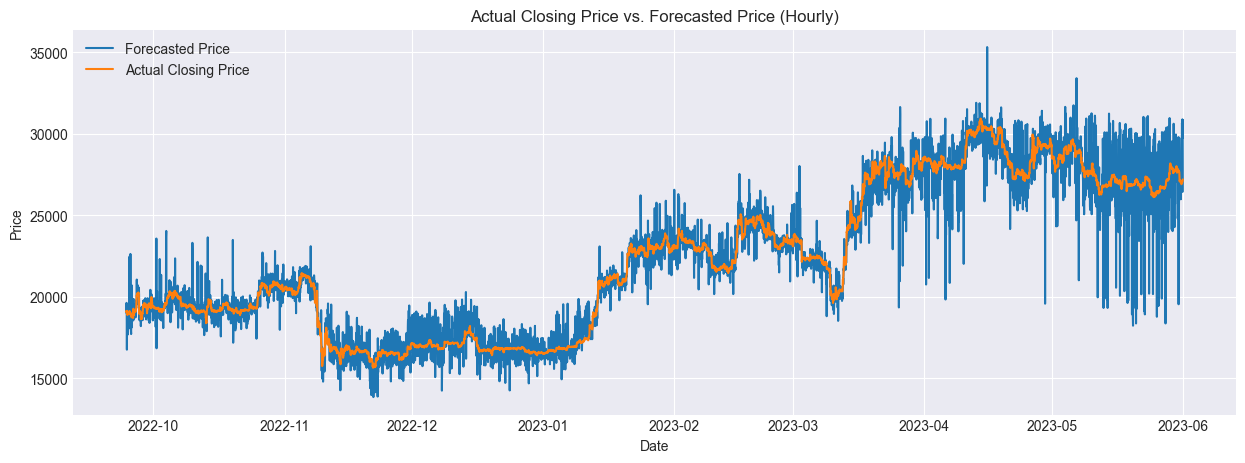

In [17]:
plt.figure(figsize=(15, 5))

plt.plot(merged_df['date'], merged_df['Forecast_XGBoost'], label='Forecasted Price')
plt.plot(merged_df['date'], merged_df['close'], label='Actual Closing Price')

plt.xlabel('Date')
plt.ylabel('Price')

plt.title('Actual Closing Price vs. Forecasted Price (Hourly)')

plt.legend()

plt.show()

In [21]:
# Results XGBoost Model

test_mae_xgboost = round(mean_absolute_error(merged_df['close'], merged_df['Forecast_XGBoost']))
test_rmse_xgboost = round(np.sqrt(mean_squared_error(merged_df['close'], merged_df['Forecast_XGBoost'])))
test_r2_xgboost = r2_score(merged_df['close'], merged_df['Forecast_XGBoost'])

print(f"test MAE XGBOOST : {test_mae_xgboost}")
print(f"test RMSE XGBOOST : {test_rmse_xgboost}")
print(f"test R2 XGBOOST : {test_r2_xgboost}")

test MAE XGBOOST : 709
test RMSE XGBOOST : 1174
test R2 XGBOOST : 0.9308637550506341
